# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
# dest_path='./data/features.csv')
# gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
# dest_path='./data/im/nevus-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
# dest_path='./data/im/nevus.jpg')
# gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
# dest_path='./data/im/melanoma-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
# dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


In [4]:
df.head()

,Id,ImageId,Malignant,f0,f1,f2,f3,f4,f5,f6,...,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29
0,0,IM_000498,0,18.183393,35.715288,0.161092,-0.004659,0.063464,27.0,23.0,...,243.0,232.0,2.183709,39.756636,16.523381,0.371835,0.599629,0.523051,0.246898,0.200719
1,1,IM_000617,0,26.113225,30.169578,0.170463,-0.035660,0.047955,25.0,16.0,...,205.0,201.0,1.789084,30.213914,17.456371,0.129085,0.309528,0.194775,0.138669,0.131058
2,2,IM_000394,0,21.629793,47.411626,0.064632,-0.017700,0.011696,54.0,44.0,...,231.0,211.0,2.591679,24.295410,17.808854,0.128401,0.340697,0.713965,0.735100,0.842481
3,3,IM_000244,0,14.753550,49.584792,0.167133,0.005986,0.048707,53.0,45.0,...,174.0,185.0,16.678174,46.491809,19.420675,0.193621,0.447559,0.360376,0.348889,0.332280
4,4,IM_000599,0,6.095158,53.635142,0.174372,-0.013851,0.055667,51.0,46.0,...,236.0,225.0,8.213178,42.538338,29.190553,0.158083,0.425375,0.682795,0.433356,0.376376


In [5]:
print(f"X is the vector {X.shape}")
print(f"y is the vector {y.shape}")

X is the vector (600, 30)
y is the vector (600,)


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

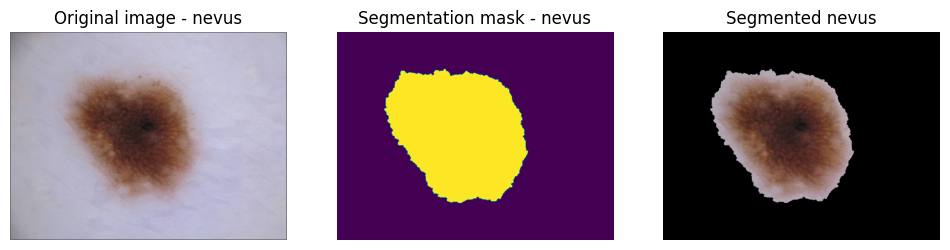

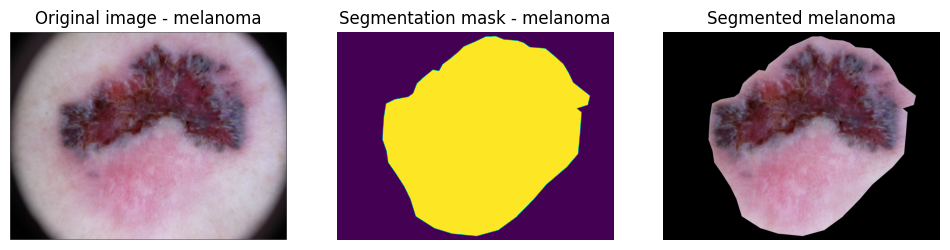

In [6]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [7]:
# Shuffle data randomly
permut_ind = np.random.permutation(X.shape[0])
Xp = X[permut_ind, :] #random permutation of the lines
yp = y[permut_ind] #following the same permutation of X

We should now test the discriminative power of our features. First, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

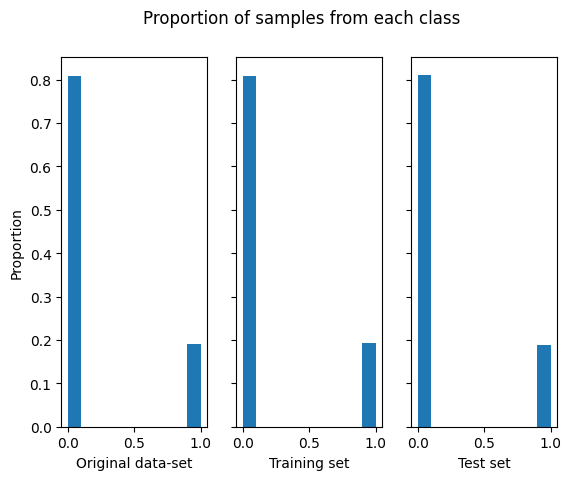

In [8]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

I cannot use the mean and variance of test set because doing that I'll give informations of it to our model during the training process. So, we should get the mean and variance of the training set after use that to also standardize our test data.  

In [9]:
# Scale data (each feature will have average equal to 0 and unit variance)
def standardize(data,X):
    '''
    Inputs:
    data (np.array): the data that we want standardize
    X (np.array) : the data that we use the information to standardize

    Return:
    the standardized data
    '''
    return (data-X.mean())/X.std()

X_train_std = standardize(X_train, X_train)
X_test_std = standardize(X_test, X_train)


In [10]:
print("Before do standardization: ")
print(f"Xtrain : mean = {X_train.mean():.2f}; variance = {X_train.var():.2f}")
print(f"Xtest : mean = {X_test.mean():.2f}; variance = {X_test.var():.2f}")
print('\n')
print("After do standardization: ")
print(f"Xtrain : mean = {X_train_std.mean():.2f}; variance = {X_train_std.var():.2f}")
print(f"Xtest : mean = {X_test_std.mean():.2f}; variance = {X_test_std.var():.2f}")


Before do standardization: 
Xtrain : mean = 50.34; variance = 4993.25
Xtest : mean = 50.35; variance = 4985.45


After do standardization: 
Xtrain : mean = 0.00; variance = 1.00
Xtest : mean = 0.00; variance = 1.00


Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       146
           1       0.53      0.29      0.38        34

    accuracy                           0.82       180
   macro avg       0.69      0.62      0.63       180
weighted avg       0.79      0.82      0.80       180

Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.70588235 0.29411765]]


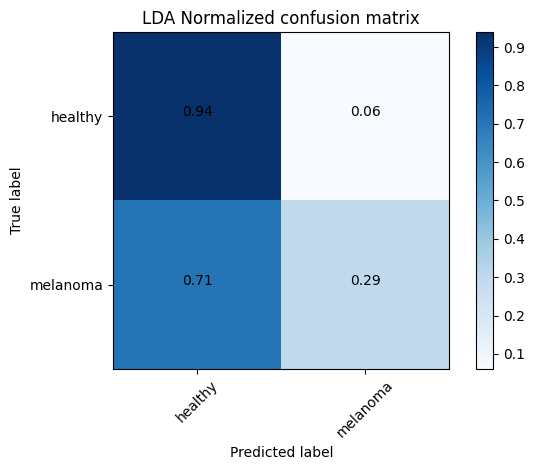

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       146
           1       0.35      0.18      0.24        34

    accuracy                           0.78       180
   macro avg       0.59      0.55      0.55       180
weighted avg       0.74      0.78      0.75       180

Normalized confusion matrix
[[0.92465753 0.07534247]
 [0.82352941 0.17647059]]


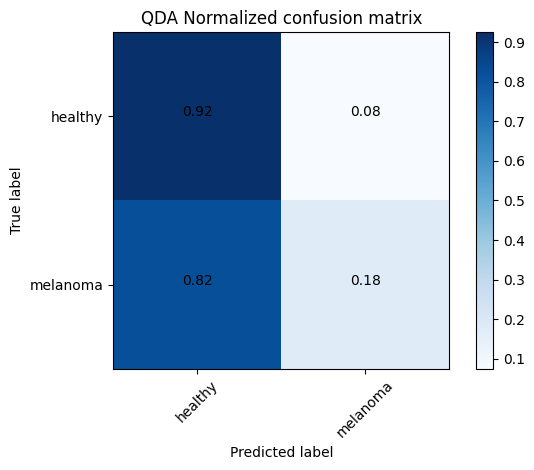

In [11]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_std, y_train)
y_pred = lda.predict(X_test_std)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_std, y_train)
y_pred = qda.predict(X_test_std)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

We can see that the precision scores of the both methods are good but we can see that the recall score of melanoma images are low. It could be also seen using the confusion matrix where the both well classified healthy images but also both missclassified melanoma images. It means that our data is imbalanced with much more healthy than melanoma images.

In [12]:
healthy_count = df['Malignant'][df['Malignant'] == 0].count()
melanoma_count = df['Malignant'][df['Malignant'] == 1].count()

print(f"The number of healthy images are:  {healthy_count}")
print(f"The number of melanoma images are: {melanoma_count}")

The number of healthy images are:  485
The number of melanoma images are: 115


The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

In [13]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
scores = cross_val_score(lda, X_train_std, y_train, cv=5)
print("Mean cross-validation score: ", scores.mean())

# Fitting QDA
print("Fitting QDA")
qda = QuadraticDiscriminantAnalysis()
scores = cross_val_score(qda, X_train_std, y_train, cv=5)
print("Mean cross-validation score: ", scores.mean())


# Fitting K-nearest neighbour
print("Fitting KNN")
knn = KNeighborsClassifier(n_neighbors = 2)
scores = cross_val_score(knn, X_train_std, y_train, cv=5)
print("Mean cross-validation score: ", scores.mean())


Fitting LDA
Mean cross-validation score:  0.8166666666666668
Fitting QDA
Mean cross-validation score:  0.8333333333333333
Fitting KNN
Mean cross-validation score:  0.7833333333333332


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

Best training Score: 0.8047619047619048
Best training params: {'n_neighbors': 10}
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


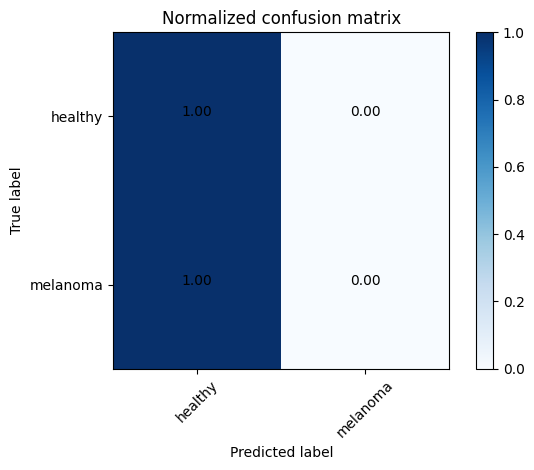

In [14]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_std, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

We can see that the score is better than the previous KNN score using cross-validation but it doesn't mean a better prediction. Seen the confusion matrix we can see that our model learned to always classify the images as healthy. This happened due to the imbalanced dataset.  

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Taking in account that our data is based in medical data and that our model will be used for after an especialist be consulted, we can say that is better when our prediction is false saying that exists a disease where there not than the contrary case. So, a more appropriate scoring could be the recall:

$recall = \frac{TP}{TP+FN}$

Best training Score: 0.2595588235294118
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.85294118 0.14705882]]


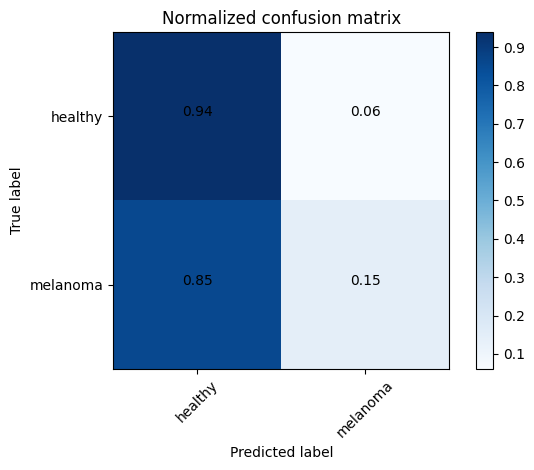

In [15]:
# Looking for the best hyperparameters

p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_train_std, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

First with the naive random over-sampling

In [16]:
from imblearn.over_sampling import ADASYN
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_std, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 339)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.9911764705882353
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.85294118 0.14705882]]


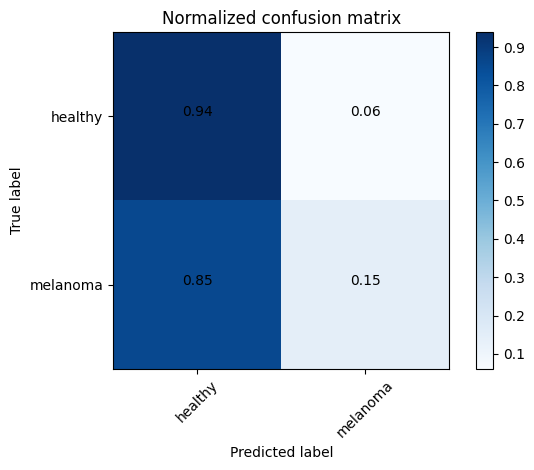

In [17]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Now with the ADASYN algorithm

In [18]:
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_std, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 360)]


Best training Score: 0.9722222222222223
Best training params: {'n_neighbors': 5}
Normalized confusion matrix
[[0.83561644 0.16438356]
 [0.73529412 0.26470588]]


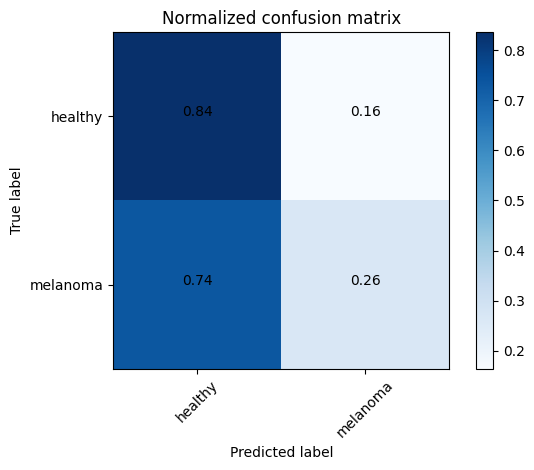

In [19]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [20]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.8029166666666667 +- 0.013083598723422983
 Average and std TEST CV accuracy : 0.7933333333333333 +- 0.021984843263788207
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.68875 +- 0.24439409203624832
 Average and std TEST CV accuracy : 0.6799999999999999 +- 0.2401157128460267


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [21]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.8029166666666667 +- 0.013083598723422983
 Average and std TEST CV accuracy : 0.7933333333333333 +- 0.021984843263788207
 Average and std TRAIN CV f1 : 0.13685684074648796 +- 0.1320500334072077
 Average and std TEST CV f1 : 0.09919484702093398 +- 0.13691805738446555
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8074999999999999 +- 0.0067956276792916805
 Average and std TEST CV accuracy : 0.7933333333333333 +- 0.015275252316519465
 Average and std TRAIN CV f1 : 0.08150764923539863 +- 0.08632652131224378
 Average and std TEST CV f1 : 0.025806451612903226 +- 0.05161290322580645


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

In [22]:
X_resampled_All, y_resampled_All = ros.fit_resample(Xp, yp)

# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.5698153942428035 +- 0.038127842990830746
 Average and std TEST CV accuracy : 0.5215477386934674 +- 0.04173118172292413
 Average and std TRAIN CV f1 : 0.46263122878427143 +- 0.2211704529869791
 Average and std TEST CV f1 : 0.39439842352496324 +- 0.1705961574306089
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5245303504380475 +- 0.033251344843392656
 Average and std TEST CV accuracy : 0.5324924623115578 +- 0.05201541350736688
 Average and std TRAIN CV f1 : 0.4295222839796322 +- 0.31803220116415015
 Average and std TEST CV f1 : 0.4317701853395538 +- 0.3306262740442986


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.553991822131357 +- 0.03787047037824081
 Average and std TEST CV accuracy : 0.5636793422404933 +- 0.052532428429806995
 Average and std TRAIN CV f1 : 0.5768260943760072 +- 0.23712150588892908
 Average and std TEST CV f1 : 0.5780182256034784 +- 0.23773430143249852
Normalized confusion matrix
[[0.02739726 0.97260274]
 [0.         1.        ]]


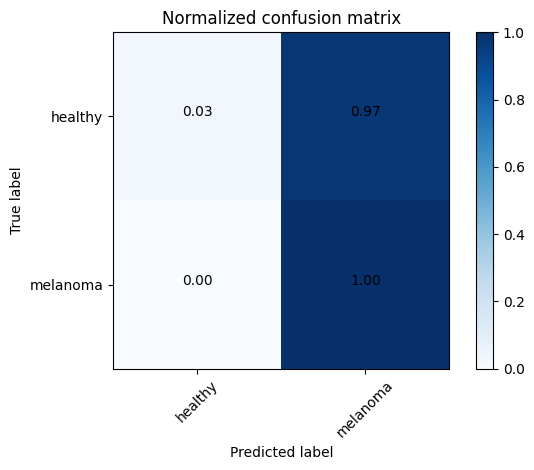

In [23]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),
                         return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.5190134543178975 +- 0.021012368460910067
 Average and std TEST CV accuracy : 0.5075025125628141 +- 0.013415472396592945
 Average and std TRAIN CV f1 : 0.35600161681441483 +- 0.27985901935108687
 Average and std TEST CV f1 : 0.32330217573660086 +- 0.2943276001620377
Normalized confusion matrix
[[0.06164384 0.93835616]
 [0.         1.        ]]


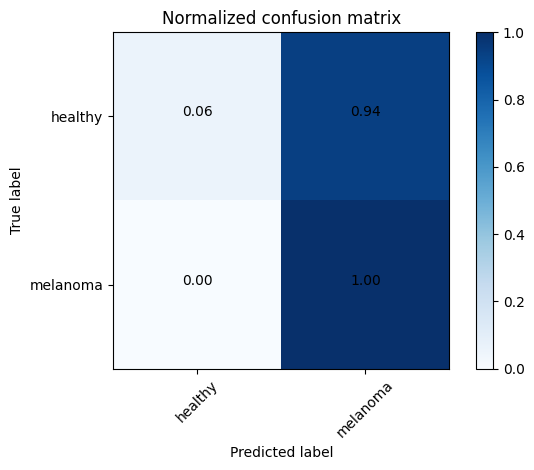

In [24]:
# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All, cv=5,scoring=('accuracy', 'f1'), 
                         return_train_score=True, return_estimator=True)

print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.6342894142809925
Best training params: {'C': 0.001}
Normalized confusion matrix
[[0.47260274 0.52739726]
 [0.17647059 0.82352941]]


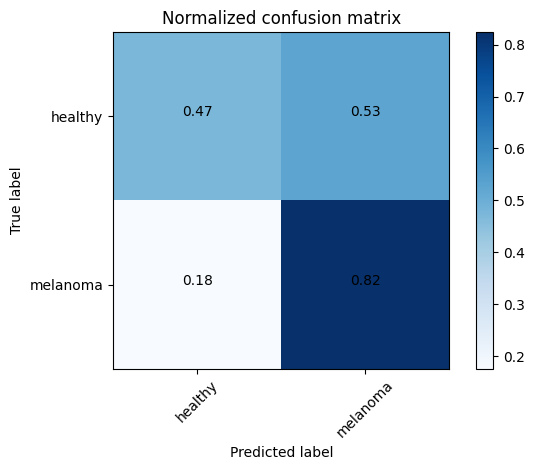

In [25]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring='f1', cv=5) 
grid_lsvm.fit(X_resampled_All, y_resampled_All)

print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.9474673089447455
Best training params: {'C': 2, 'gamma': 0.001}
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


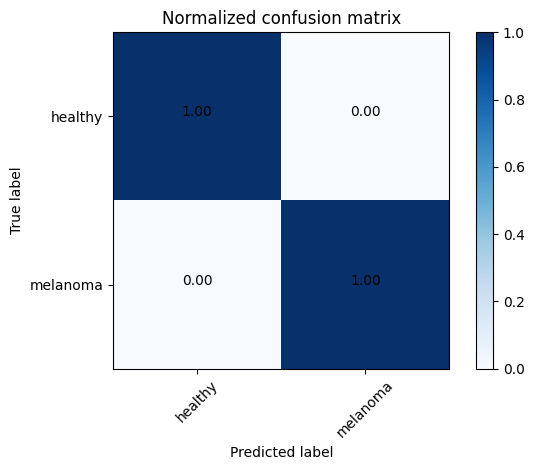

In [26]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring='f1', cv=5) 
grid_nlsvm.fit(X_resampled_All, y_resampled_All)

print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

Yes. The changes are due the fact that each scoring function penalize different the FN and FP values. Moreover, since our data are imbalanced, oversampling it permits our model learn and not only give the naive response (always predicting the class with more data).    

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

The non-linear SVM using radial basis function presented the best results only looking for the scores. Maybe, one important point before use it is not an overfitting happening. The f1 score do a trade-off of precision and recall scores so it could be a good one to choose. Moreover, how already said, working with medical data is better have FP than FN so, in this context, the recall score is more important than the precision.  It's not worth to oversample one of the two classes since new samples may not be representative of the true distribution of the data, and they may introduce bias and affect the decision boundary of the model.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [ ]:
# Test PCA with a linear SVM
# XXXXXXXX

In [ ]:
# Fitting Linear SVM 
# XXXXXXXXXX

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

# XXXXXXXXXX